In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


# Table Prescription Codes

In [ ]:
import random 
a = 1
b = 5

def prescribeTable():
    generatedTableList = random.sample(1, 5)
    print(generatedTableList)


NameError: ignored

In [ ]:
print(x)

4


In [ ]:
import random
def prescribeTable():
    population = range(1, 5)
    generatedTableList = random.sample(population, 4)
    for i in range(len((generatedTableList))):
        current_index = generatedTableList[i]
        computer_emitter.send(bytes([current_index]))


In [ ]:
prescribeTable()

4
2
1
3


# Analysis

## Generation Code

In [ ]:
import numpy as np
import csv
from copy import deepcopy
from functools import reduce

# Parameter values
L1_VALUE = 0.3302
L2_VALUE = 0.2794
L3_VALUE = 0.1016
L4_VALUE = 0.2286

class wayPoints:
    def __init__(self,filename = None):
        self.waypoints = []
        if filename != None:
            self.readFromFile(filename)
        
    def addWP(self,wp):
        #wp is (j1,j2,jn,t) tuple
        self.waypoints.append(wp)
        
    def readFromFile(self,filename):
        #assuming CSV file
        with open(filename,newline='') as wpFile:
            wpReader = csv.reader(wpFile, delimiter=',', quotechar='|')
            for wp in wpReader:
                newRow = [float(val) for val in wp]
                self.addWP(tuple(newRow))

class trajectoryPlanner:
    def __init__(self, jointNum):
        self.jointNum = jointNum
        self.method = None
        
    def waypointsParse(self,wayP,method):
        #interpret a list of waypoints
        #list of tuples, [(joint1_i,joint2_i,...,t_i)...]
        #interpolate between points with method
        self.method = method
        
        if len(wayP) < 2:
            print("not enough waypoints!")
            return
        
        #check for positive time increments
        tLast = 0
        for waypoint in wayP:
            tDiff = waypoint[-1]-tLast
            tLast = waypoint[-1]
            if tDiff < 0:
                print("not a positive time sequence!")
                return
        
        if len(wayP[0])-1 != self.jointNum:
            print("waypoints/joint mismatch!")
            return
        
        self.joints = []
        for i in range(self.jointNum):
            self.joints.append([])
        
        #split waypoints into individual [(position,time)] per joint
        for waypoint in wayP:
            for i in range(self.jointNum):
                self.joints[i].append([waypoint[i],waypoint[-1]])

        #joints[] is now a list of points,time per joint
        if method == "cubic":
            #cubic interpolation
            self.cubicInterpolate()
        elif method == "quintic":
            #quintic interpolation
            self.quinticInterpolate()
        elif method == "trapVel":
            self.trapVelInterpolate()
        else:
            pass
            
    def trapVelInterpolate(self):
        #interpolate between points with trapezoidal velocity
        #later - respect max velocity and acceleration constraints
        #no blending - stop at waypoints.
        pass
        
            
    def cubicInterpolate(self):
        #for each joint, calculate the coefficients for the cubic
        #interpolating polynomials
        
        #modify joints from [position,time] to [position,velocity,time]
        self.cubicCoeffs = []
        for j in self.joints:
            self.cubicCoeffs.append([])
        
        #null starting and ending velocity
        for j in self.joints:
            for i in range(len(j)):
                j[i].insert(1,0)
            
        #compute intermediate velocities
        #if the last and next velocities are of different sign, make 
        #velocity = 0 at that point.    
        for j in self.joints:
            for i in range(1,len(j)-1):
                #(pos-lastPos)/(tdiffLast)
                velBefore = (j[i][0]-j[i-1][0])/(j[i][-1]-j[i-1][-1])
                #(nextPos-pos)/(tdiffNext)
                velAfter = (j[i+1][0]-j[i][0])/(j[i+1][-1]-j[i][-1])
                if sign(velBefore) == sign(velAfter):
                    intermediateVelocity = (1/2)*(velBefore+velAfter)
                else:
                    # intermediateVelocity = 0
                    intermediateVelocity = (1/2)*(velBefore+velAfter)
                j[i][1] = intermediateVelocity
        
        #now, do the interpolation
        #treat each points starting time as 0, simpler math
        for num,j in enumerate(self.joints):
            for i in range(len(j)-1):
                #calculate a3...a0 for the cubic polynomial between
                #each pair of points
                
                qi = j[i][0]
                qi_dot = j[i][1]
                qf = j[i+1][0]
                qf_dot = j[i+1][1]
                tf = j[i+1][-1]-j[i][-1]
                
                A = np.array([[1,0,0,0],[0,1,0,0],[1,tf,tf**2,tf**3],[0,1,2*tf,3*tf**2]])
                B = np.array([[qi],[qi_dot],[qf],[qf_dot]])
                coeffs = np.linalg.solve(A,B)
                coeffs = np.append(coeffs,tf)
                self.cubicCoeffs[num].append(coeffs)
                
                
        
    def quinticInterpolate(self):
        #same as cubic but with continuous accelerations
        
        #modify joints from [position,time] to [position,velocity,accel,time]
        self.quinticCoeffs = []
        for j in self.joints:
            self.quinticCoeffs.append([])
        
        #null starting and ending velocity and acceleration
        for j in self.joints:
            for i in range(len(j)):
                j[i].insert(1,0)
                j[i].insert(1,0)
            
        #compute intermediate velocities
        #if the last and next velocities are of different sign, make 
        #velocity = 0 at that point.    
        for j in self.joints:
            for i in range(1,len(j)-1):
                #(pos-lastPos)/(tdiffLast)
                velBefore = (j[i][0]-j[i-1][0])/(j[i][-1]-j[i-1][-1])
                #(nextPos-pos)/(tdiffNext)
                velAfter = (j[i+1][0]-j[i][0])/(j[i+1][-1]-j[i][-1])
                if sign(velBefore) == sign(velAfter):
                    intermediateVelocity = (1/2)*(velBefore+velAfter)
                else:
                    intermediateVelocity = 0
                j[i][1] = intermediateVelocity
                
        #compute intermediate accelerations
        #if the last an next accel are diff sign, make accel = 0
        #at midpoint
        for j in self.joints:
            for i in range(1,len(j)-1):
                #(vel-lastVel)/(tdiffLast)
                accelBefore = (j[i][1]-j[i-1][1])/(j[i][-1]-j[i-1][-1])
                #(nextVel-vel)/(tdiffNext)
                accelAfter = (j[i+1][1]-j[i][1])/(j[i+1][-1]-j[i][-1])
                if sign(accelBefore) == sign(accelAfter):
                    intermediateAccel = (1/2)*(accelBefore+accelAfter)
                else:
                    intermediateAccel = 0
                j[i][2] = intermediateAccel
        
        #now, do the interpolation
        #treat each points starting time as 0, simpler math
        for num,j in enumerate(self.joints):
            for i in range(len(j)-1):
                #calculate a3...a0 for the cubic polynomial between
                #each pair of points
                
                qi = j[i][0]
                qi_dot = j[i][1]
                qi_ddot = j[i][2]
                qf = j[i+1][0]
                qf_dot = j[i+1][1]
                qf_ddot = j[i+1][2]
                tf = j[i+1][-1]-j[i][-1]
                
                A = np.array([[1,0,0,0,0,0],[0,1,0,0,0,0],[0,0,2,0,0,0],[1,tf,tf**2,tf**3,tf**4,tf**5],[0,1,2*tf,3*tf**2,4*tf**3,5*tf**4],[0,0,2,6*tf,12*tf**2,20*tf**3]])
                B = np.array([[qi],[qi_dot],[qi_ddot],[qf],[qf_dot],[qf_ddot]])
                coeffs = np.linalg.solve(A,B)
                coeffs = np.append(coeffs,tf)
                self.quinticCoeffs[num].append(coeffs)
        
    def calcOutputs(self,Ts):
        
        #calculate p,v,a outputs for each joint
        #sample polynomials with time interval Ts
        
        #self.outputs is a list, [[[j1_pi,j1_vi,j1_ai],...]...]
        self.outputs = []
        for j in self.joints:
            self.outputs.append([])
            
        if self.method == None:
            print("Paths have not been interpolated")
            return
        elif self.method == "cubic":
            i = 0
            for joint in self.cubicCoeffs:
                for j, c in enumerate(joint):
                    if j == 0:
                        #create 1st value
                        _t = 0
                        p = c[0] + c[1]*_t + c[2]*_t**2 + c[3]*_t**3
                        v = c[1] + 2*c[2]*_t + 3*c[3]*_t**2
                        a = 2*c[2] + 6*c[3]*_t
                        self.outputs[i].append([p,v,a])
                        
                    for _t in np.arange(Ts,c[-1]+Ts,Ts):
                        p = c[0] + c[1]*_t + c[2]*_t**2 + c[3]*_t**3
                        v = c[1] + 2*c[2]*_t + 3*c[3]*_t**2
                        a = 2*c[2] + 6*c[3]*_t
                        self.outputs[i].append([p,v,a])
                        
                i = i + 1
        elif self.method == "quintic":
            i = 0
            for joint in self.quinticCoeffs:
                for j, c in enumerate(joint):
                    if j == 0:
                        #create 1st value
                        _t = 0
                        p = c[0] + c[1]*_t + c[2]*_t**2 + c[3]*_t**3 + c[4]*_t**4 + c[5]*_t**5
                        v = c[1] + 2*c[2]*_t + 3*c[3]*_t**2 + 4*c[4]*_t**3 + 5*c[5]*_t**4
                        a = 2*c[2] + 6*c[3]*_t + 12*c[4]*_t**2 + 20*c[5]*_t**3
                        self.outputs[i].append([p,v,a])
                        
                    for _t in np.arange(Ts,c[-1]+Ts,Ts):
                        p = c[0] + c[1]*_t + c[2]*_t**2 + c[3]*_t**3 + c[4]*_t**4 + c[5]*_t**5
                        v = c[1] + 2*c[2]*_t + 3*c[3]*_t**2 + 4*c[4]*_t**3 + 5*c[5]*_t**4
                        a = 2*c[2] + 6*c[3]*_t + 12*c[4]*_t**2 + 20*c[5]*_t**3
                        self.outputs[i].append([p,v,a])
                        
                i = i + 1
        elif self.method == "trapVel":
            pass
        else:
            return

###################### Required Functions ######################

       
def sign(num):
    if num > 0:
        return 1
    elif num < 0:
        return -1
    else:
        return 0

def speedChange(waypoints, multiplier):
    newPoints = []
    for i in range(len(waypoints)):
        newPoints.append((waypoints[i][0],waypoints[i][1],waypoints[i][2]*multiplier))
    return newPoints
    
def generateWaypoints(theta1_, theta2_, theta3_, time, theta_sampling_rate=0.003):
    theta1 = np.deg2rad(theta1_)
    theta2 = np.deg2rad(theta2_)
    theta3 = np.deg2rad(theta3_)
    #Product of all 3 angles will be a multiple of LCM of 3 angles
    theta = theta1 * theta2 * theta3

    if theta < 0:
        theta = -theta


    theta_iterator = np.arange(0,theta,theta_sampling_rate)

    waypoints_arr = list()

    time_arr = np.linspace(0, time,theta_iterator.size)
    j = 0
    for i in theta_iterator:
        tt1 = (i* theta1) / theta
        tt2 = (i* theta2) / theta
        tt3 = (i* theta3) / theta
        tuple_saved =  deepcopy( (tt1, tt2, tt3, time_arr[j]) )
        waypoints_arr.append( tuple_saved )
        j +=1
    return waypoints_arr
    
def generateWaypointModified(theta1, theta2, theta3, tf, iteration_steps=0.001):
    '''
    Takes in theta1, theta2, theta3
    returns waypoints

    Input: theta1, theta2, theta3, tf, iteration_steps
    Output: waypoints p1, p2, p3
    '''    
    T = np.arange(0, tf, iteration_steps)
    waypoints_arr = list()

    for i in T:
        pos1,_,_ = cubic_polynomial(np.deg2rad(theta1),tf,i)
        pos2,_,_ = cubic_polynomial(np.deg2rad(theta2),tf,i)
        pos3,_,_ = cubic_polynomial(np.deg2rad(theta3),tf,i)
        waypoints_arr.append((pos1, pos2, pos3, i) )

    return waypoints_arr       
    
###################### Kinematic Modelling Functions ######################

def forward_kinematics(theta1,theta2,theta3) -> np.array:
    '''
    Takes in angle theta1, theta2, theta3
    and returns the coordinates x,y, and phi

    Input: theta1, theta2, theta2
    Output: np.array of outputs [x,y,phi]
    '''
    # Link Parameters
    L1 = L1_VALUE  #length of the first segment 
    L2 = L2_VALUE  #length of the second segment
    L4 = L4_VALUE

    x = np.array([0, L1, L1+L2, L4+L1+L2]);
    y = np.array([0., 0., 0., 0.]);

    # Convert to radians
    tt1 = np.deg2rad(theta1)
    tt2 = np.deg2rad(theta2)
    tt3 = np.deg2rad(theta3)

    # Rotation Matrices
    R1 = Rotate(tt1)
    R2 = Rotate(tt2)
    R3 = Rotate(tt3)

    # Translation Matrices
    # Parameters are link lengths
    T2 = Translate(L1)
    T3 = Translate(L2)
    T4 = Translate(L4)

    # First joint position
    # Transformation matrix

    a = np.array([[0],[0],[0],[1]])
    Y_iter1 = reduce(np.dot, [R1,T2])
    # Finding new coordinates
    Y1 = np.dot(Y_iter1, a)

    x[1] = Y1[0]
    y[1] = Y1[1]

    # Finding third point
    # transformation matrix
    Y_iter2 = reduce(np.dot, [R1,T2,R2,T3])
    # Finding new coordinates
    Y2 = np.dot(Y_iter2, a)
    x[2] = Y2[0]
    y[2] = Y2[1]

    # finding fourth point

    # transformation matrix
    Y_iter3 = reduce(np.dot, [R1,T2,R2,T3,R3,T4])

    # Finding new coordinates
    Y3 = np.dot(Y_iter3, a)

    x[3] = Y3[0]
    y[3] = Y3[1]

    phi = np.rad2deg(tt1+tt2+tt3)
    return x,y,phi

    
def inv_kinematics(x_goal,y_goal,phi_goal_) -> [np.float64, np.float64, np.float64]:
    '''
    Function to derive angles theta1, theta2, theta3
    based on target locations x_goal,y_goal, phi_goal

    Input: x_goal,y_goal,phi_goal
    Output: theta1, theta2, theta3 in degrees
    '''
    phi_goal = np.deg2rad(phi_goal_)
    l1 = L1_VALUE   #length of the first segment 
    l2 = L2_VALUE   #length of the second segment
    l4 = L4_VALUE   
     
    x1 = x_goal - l4*np.cos(phi_goal)
    y1 = y_goal - l4*np.sin(phi_goal)
    A = -2*l1*x1
    B = -2*l1*y1
    alpha = np.arctan2(B/(np.sqrt(A**2+B**2)), A/(np.sqrt(A**2+B**2)))
    #sign = np.array([1,-1])
    theta1 = alpha + np.arccos(-(x1**2+y1**2+l1**2-l2**2)/(2*l1*np.sqrt(x1**2+y1**2)))
    theta2 = np.arccos((x1**2+y1**2-l1**2-l2**2)/(2*l1*l2))
    theta3 = phi_goal-theta1-theta2

    return [np.rad2deg(theta1), np.rad2deg(theta2), np.rad2deg(theta3)]
    
def cubic_polynomial(theta_f, t_f, t):
    #constraints: 
    theta_0 = 0; # initial position is 0
    #dot_theta_0 = 0; %initial velocity is zero 
    #dot_theta_f = 0 %final velocity is zero 

    #calculated coefficients 
    a0 = theta_0
    a1 = 0
    a2 = (3/t_f**2)*(theta_f - theta_0)
    a3 = (-2/t_f**3)*(theta_f - theta_0)

    # angular position at time step t 
    theta_t = a0 + a1*t + a2*t**2 + a3*t**3

    # angular velocity at time step t 
    angular_vel = a1 + 2*a2*t + 3*a3*t**2

    # angular acceleration at time step t
    angular_acc = 2*a2 + 6*a3*t

    return theta_t,angular_vel,angular_acc

###################### Auxiliary Functions ######################


def Translate(d) -> np.array: 
    '''
    Translate returns translation matrix 
    Returns translation matrix using displacement d 

    Input: Distance d from current point
    Output: Array T
    '''
    # T = np.array([[1,0,0,d], [0,1,0,0], [0,0,1,0], [0,0,0,1]])
    T = np.eye(4) + [[0,0,0,d],[0,0,0,0],[0,0,0,0],[0,0,0,0]]
    return T

def Rotate(theta) -> np.array:
    '''
    Function returns rotation matrix 
    Input angle theta is used to create 3x3 rotation matrix 
    '''
    c = np.cos(theta)
    s = np.sin(theta)
    R = np.array([[c,-s,0,0],[s,c,0,0],[0,0,1,0],[0,0,0,1]])
    return R

## Processing Code

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import random
import sys
from itertools import groupby


sns.set_style('whitegrid')

In [ ]:
working_directory = '/content/drive/MyDrive/183DB/Week 11/Data'
os.chdir(working_directory)
os.getcwd()

'/content/drive/MyDrive/183DB/Week 11/Data'

In [ ]:
def saveFileName(df_obj, filename, dir='Data'):
    '''
    Saves csv to file using `filename` in `directory` provided
    
    Input: 
    df_obj - pandas dataFrame object
    filename - string
    dir - string
    
    Output:
    None
    '''
    # Get current directory
    # curr_dir = '/content/drive/MyDrive/183DB/Week 11'
    # working_directory = os.path.join(curr_dir, dir)
    working_directory = '/content/drive/MyDrive/183DB/Week 11/Data'
    # Check operating system
    if sys.platform == 'darwin':
        # save_name = f"{working_directory}/{filename}"
        save_name = f'{filename}'
    else:
        # save_name = f"{working_directory}\\{filename}"
        save_name = f'{filename}'
    df_obj.to_csv(save_name, index=False)

In [ ]:
timeStep = 5

mu_dict = {1: 0,
           2: 0,
           3: 0}

sigma_dict = {1:0.00436332,
              2:0.00436332,
              3:0.00436332}

range_dict = {1: [-64.93, 64.93],
              2: [-64.93, 64.93],
              3: [-97.9, 97.9]}

def originPosition():
    theta1_or = -1.91829
    theta2_or = -1.22836
    theta3_or = 1.56573
    return (theta1_or, theta2_or,theta3_or, 0)

def generateNoise(joint_number, dimension_array):
    '''
    Generates noise based on motor specifications
    Joint 1
    Joint 2
    Joint 3
    Returns numpy array to add 
    '''
    mu = mu_dict[joint_number]
    sigma = sigma_dict[joint_number]
    return np.random.normal(mu, sigma, dimension_array)

def generateVelocities(theta1_, theta2_, theta3_, 
                       runtime_,
                       noise_enabled=False,
                       saveStatus = False,
                       fileNumber=0,
                       plottingData = False):
    
    if noise_enabled  == True:
        noise_constant = 1
    else:
        noise_constant = 0

    fileNumber_append = str(fileNumber).zfill(3)
    theta1= np.deg2rad(theta1_)
    theta2= np.deg2rad(theta2_)
    theta3= np.deg2rad(theta3_)

    traj_li = list([])
    joint_li = list([])
    waypoints = [originPosition(),(theta1,theta2,theta3,runtime_)]
    tp = trajectoryPlanner(3)
    tp.waypointsParse(waypoints, "quintic")
    tp.calcOutputs(timeStep/1000)
    # Position, Velocity, and Acceleration
    jointOutputs = np.array([tp.outputs[0], tp.outputs[1], tp.outputs[2]])
    i= 1
    for j in jointOutputs:
        array_length = np.array(j[:,0]).size
        time_data = np.linspace(0,runtime_, array_length)
        position_data = np.array(j[:,0]) + noise_constant*(generateNoise(i, array_length))
        velocity_data = np.array(j[:,1]) + noise_constant*(generateNoise(i, array_length))
        acceleration_data = np.array(j[:,2]) + noise_constant*(generateNoise(i, array_length))

        # velocity_data = np.gradient(position_data, time_data)
        # acceleration_data = np.gradient(velocity_data, time_data)
        outputData = pd.DataFrame(np.column_stack((time_data,position_data,velocity_data,acceleration_data )),
                                  columns= ['time', 'position', 'velocity', 'acceleration'])
        cleanData = pd.DataFrame(np.column_stack((time_data,
                                                  np.array(j[:,0]),
                                                  np.array(j[:,1]),
                                                  np.array(j[:,2]))),
                                 columns= ['time', 'position', 'velocity', 'acceleration'])
        if plottingData == True:
            plt.scatter(time_data, acceleration_data, label=f'Joint {i} Actual',alpha=0.2)
            plt.plot(time_data, np.array(j[:,2]), label=f'Joint {i} Theoretical',
                    linewidth=2)
            # plt.ylabel(r'Velocity ($rad s^{-1}$)')
            plt.ylabel(r'Position ($rad$)')
            plt.xlabel('Time (s)')
            plt.legend()

        if saveStatus == True:
            filename = f'joint_{i}_{fileNumber_append}.csv'
            filename_clean = f'theoretical_joint_{i}_{fileNumber_append}.csv'
            saveFileName(outputData,filename)
            saveFileName(cleanData,filename_clean)
        i+=1

def measureMotionBulk(number_of_trials=50):
    '''
    Measures the motion of specified number of  trials
    Returns the CSV of the number of trials
    '''
    for i in range(number_of_trials):
        gen_theta1 = np.deg2rad(random.uniform(range_dict[1][0], range_dict[1][1]))
        gen_theta2 = np.deg2rad(random.uniform(range_dict[2][0], range_dict[2][1]))
        gen_theta3 = np.deg2rad(random.uniform(range_dict[3][0], range_dict[3][1]))
        generateVelocities(gen_theta1,gen_theta2,gen_theta3,6,
                                    True, True, i +1)
        
    print(f'Generated {number_of_trials} trajectories')

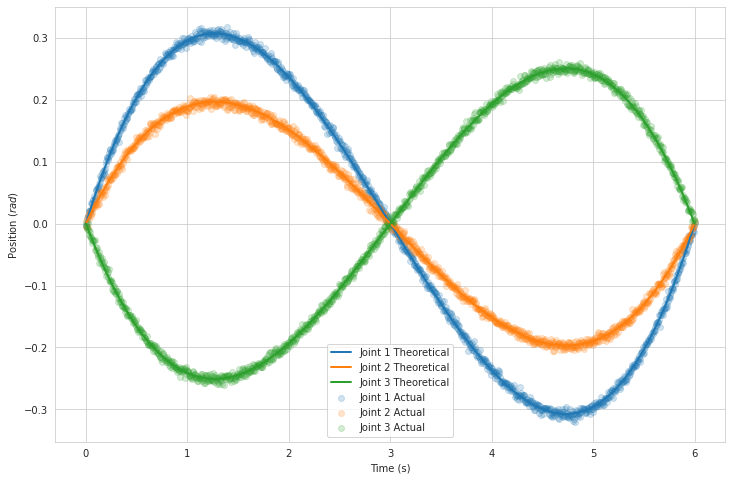

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
generateVelocities(0,0,0,
                   6,
                   True,
                   False,
                   0,
                   True)

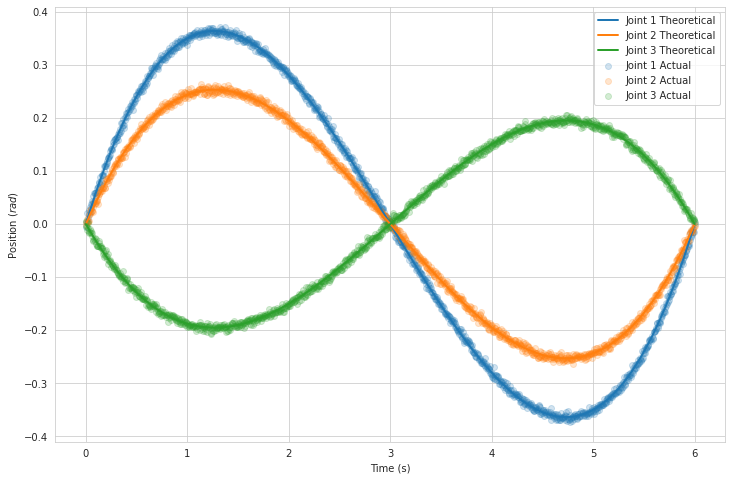

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

generateVelocities(20,20,20,
                   6,
                   True,
                   False,
                   0,
                   True)

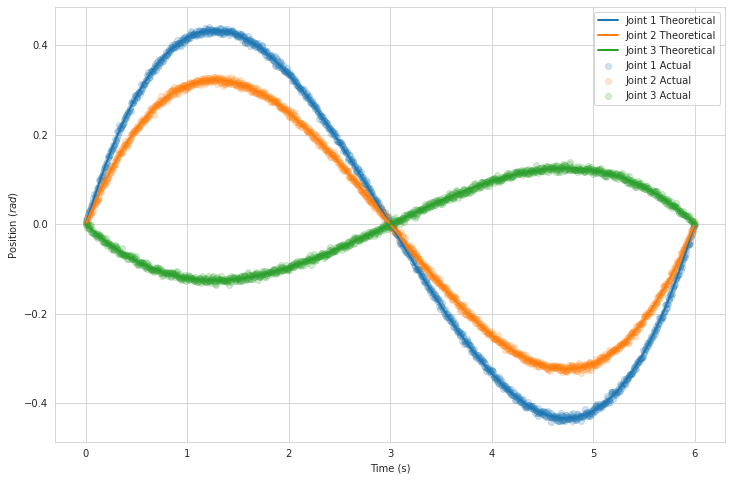

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

generateVelocities(45,45,45,
                   6,
                   True,
                   False,
                   0,
                   True)

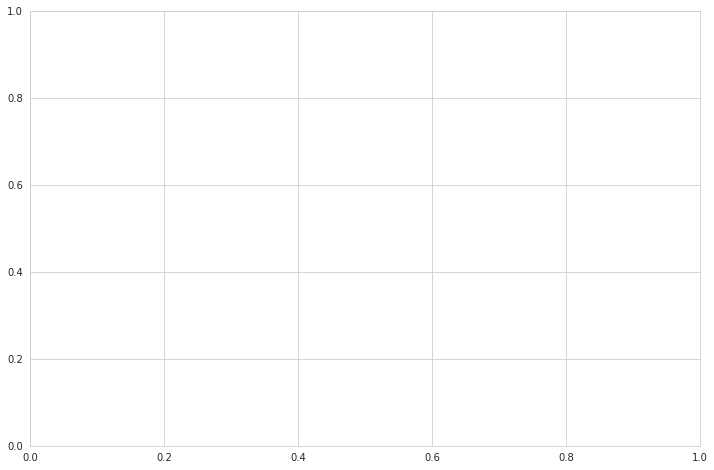

In [ ]:
fig , ax = plt.subplots(figsize=(12,8))
generateVelocities(0,0,0,6, True)

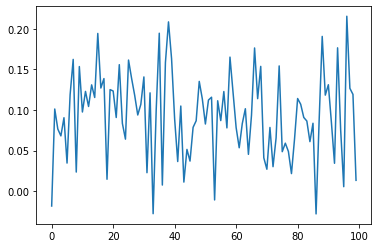

In [ ]:
plt.plot(generateNoise(1, 100))

## Error Analysis Codes

In [ ]:
INDEXED_PARAMETERS = ['time','position', 'velocity', 'acceleration']
PARAMETER_UNITS = ['time', r'$rad$', r'$rad s^{-1}$', '(J)', r'$rad s^{-2}$']

def analyzeMotion(dirname= os.getcwd(), parameter_index=2):
    '''
    Analyzes the motion of the collision
    dirnames_:
        directory of the data

    parameter_index:
        0 - position
        1 - velocity
        2 - acceleration
    '''

    for f in dirname:
        # Load current directory
        curr_dir = os.getcwd()


In [ ]:
def unique(list1):
     
    # insert the list to the set
    list_set = set(list1)
    # convert the set to the list
    unique_list = (list(list_set))
    for x in unique_list:
        print(x,)

In [ ]:
number_list = list()
for i in range(1000):
    indexer = str(i+1)
    number_list.append(indexer.zfill(3))

In [ ]:
from sklearn.metrics import mean_squared_error


In [ ]:
list_number = list()

joint_MSE_pos = {1:list(),
             2:list(),
             3:list()}
joint_MSE_vel = {1:list(),
             2:list(),
             3:list()}
joint_MSE_acc = {1:list(),
             2:list(),
             3:list()}    
                      
files_in_directory = os.listdir()

files_in_directory.sort(key = lambda x: int(x.rsplit('_',1)[1].split('.')[0]))
grouped_files = [list(i) for j, i in groupby(files_in_directory,
                  lambda a: a.split('.')[0].split('_')[-1])] 

for g in grouped_files:
    joint = [list(i) for j, i in groupby(g,
                  lambda a: a.split('_')[-2].split('_')[0])]
    for i in range(3):
        joint_number = i+1
        '''
        Given the joints, calculate the MSE for p,v,a
        '''
        
        actual = pd.read_csv(joint[i][0])
        theoretical = pd.read_csv(joint[i][1])
        joint_MSE_pos[joint_number].append(mean_squared_error(theoretical.position.values.T, 
                                                              actual.position.values.T,))
        joint_MSE_vel[joint_number].append(mean_squared_error(theoretical.velocity.values.T,
                                                              actual.velocity.values.T,))
        joint_MSE_acc[joint_number].append(mean_squared_error(theoretical.acceleration.values.T, 
                                                              actual.acceleration.values.T,))

In [ ]:
np.array(joint_MSE_vel[1]).mean()

0.0006196809498935605

In [ ]:
print(np.array(joint_MSE_vel[]).mean())
print(np.array(joint_MSE_vel[2]).mean())
print(np.array(joint_MSE_vel[2]).mean())

TypeError: ignored

In [ ]:
printf(grouped_files)

NameError: ignored

### End Effector Space

In [ ]:
list_number = list()

position_mse_horz = list()
position_mse_vert = list()


files_in_directory = os.listdir()

files_in_directory.sort(key = lambda x: int(x.rsplit('_',1)[1].split('.')[0]))
grouped_files = [list(i) for j, i in groupby(files_in_directory,
                  lambda a: a.split('.')[0].split('_')[-1])] 

for g in grouped_files:
    actual_list = list()        
    theoretical_list = list()
    for f in g:
        if 'theoretical' in f:
            theoretical_list.append(f)
        else:
            actual_list.append(f)            

    actual_list.sort()
    theoretical_list.sort()

    actual_x_list = list()
    actual_y_list = list()
    theo_x_list = list()
    theo_y_list = list()
    
    # Calculating theoretical values
    j1_t = pd.read_csv(theoretical_list[0])
    j2_t = pd.read_csv(theoretical_list[1])
    j3_t = pd.read_csv(theoretical_list[2])
    df_t = pd.DataFrame()
    df_t['t1'] = j1_t.position.values.T
    df_t['t2'] = j1_t.position.values.T
    df_t['t3'] = j1_t.position.values.T
    theo_x_list = list()
    theo_y_list = list()
    for i in range(j1_t.position.values.T.size):
        x_temp, y_temp, _ = forward_kinematics(np.rad2deg(df_t.t1.values.T[i]),
                                            np.rad2deg(df_t.t2.values.T[i]),
                                            np.rad2deg(df_t.t3.values.T[i]))
        theo_x_list.append(x_temp[3])
        theo_y_list.append(y_temp[3]) 

    # Calculating actual values
    j1_a = pd.read_csv(actual_list[0])
    j2_a = pd.read_csv(actual_list[1])
    j3_a = pd.read_csv(actual_list[2])
    df_a = pd.DataFrame()
    df_a['t1'] = j1_a.position.values.T
    df_a['t2'] = j2_a.position.values.T
    df_a['t3'] = j3_a.position.values.T
    act_x_list = list()
    act_y_list = list()
    for i in range(j1_t.position.values.T.size):
        x_temp, y_temp, _ = forward_kinematics(np.rad2deg(df_a.t1.values.T[i]),
                                            np.rad2deg(df_a.t2.values.T[i]),
                                            np.rad2deg(df_a.t3.values.T[i]))
        act_x_list.append(x_temp[3])
        act_y_list.append(y_temp[3]) 
    
    position_mse_horz.append(mean_squared_error(np.array(theo_x_list), 
                                                np.array(act_x_list)))
    position_mse_vert.append(mean_squared_error(np.array(theo_y_list), 
                                                np.array(act_y_list)))
    
mse_horz = np.array(position_mse_horz).mean()
mse_vert = np.array(position_mse_vert).mean()    

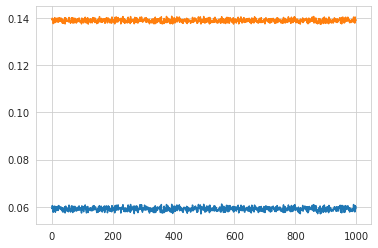

In [ ]:
plt.plot(position_mse_horz)
plt.plot(position_mse_vert)

In [ ]:
print(mse_horz, mse_vert)

0.05919987419182348 0.13895375113866604


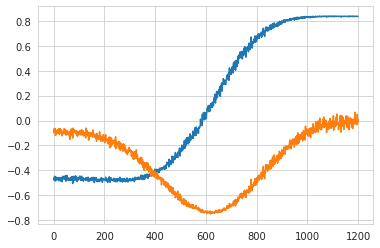

In [ ]:
test_item = ['joint_1_001.csv', 'joint_2_001.csv', 'joint_3_001.csv']

j1 = pd.read_csv('joint_1_001.csv')
j2 = pd.read_csv('joint_2_001.csv')
j3 = pd.read_csv('joint_2_001.csv')
df = pd.DataFrame()
df['t1'] = j1.position.values.T
df['t2'] = j2.position.values.T
df['t3'] = j3.position.values.T
x_ = list()
y_ = list()
for i in range(j1.position.values.T.size):
    x_temp, y_temp, _ = forward_kinematics(np.rad2deg(df.t1.values.T[i]),
                                           np.rad2deg(df.t2.values.T[i]),
                                           np.rad2deg(df.t3.values.T[i]))
    x_.append(x_temp[3])
    y_.append(y_temp[3]) 


## Fitting a regression model on our noisy data

In [ ]:
from sklearn.linear_model import LinearRegression

linReg = LinearRegression()

In [ ]:
joint_MSE

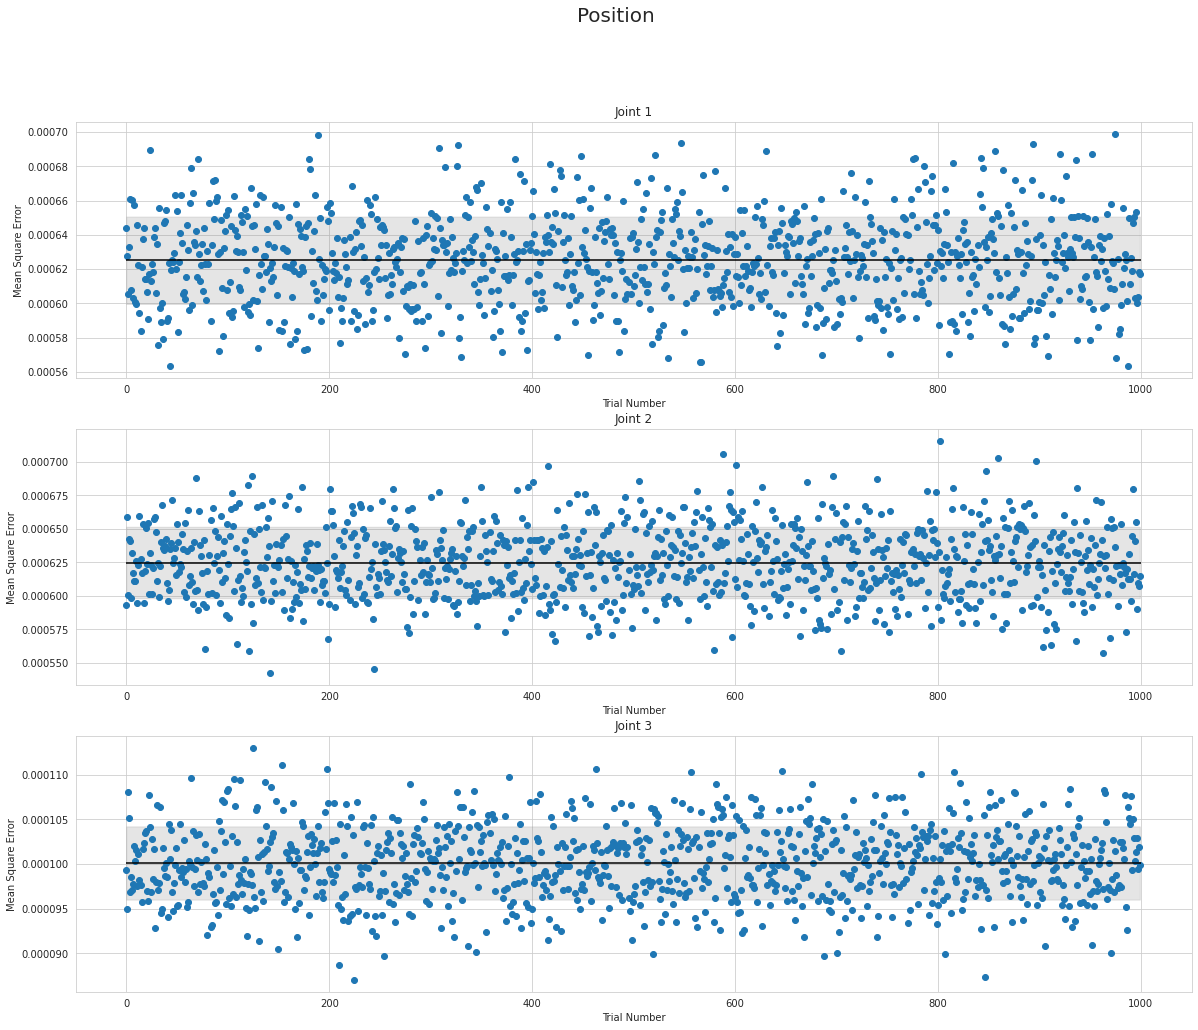

In [ ]:
fig, ax = plt.subplots(3,1,figsize=(20,16))

fig.suptitle('Position', fontsize=20)
for i in range(3):
    joint_number = i + 1
    joint_MSE_curr = joint_MSE_pos[joint_number]
    trial_arr = np.arange(len(joint_MSE_curr))

    mean_curr = np.mean(joint_MSE_curr)
    std_curr = np.std(joint_MSE_curr)
    mean_arr = np.ones(len(joint_MSE_curr))*mean_curr
    std_curr = np.std(joint_MSE_curr)
    ax[i].hlines(mean_curr, 0, len(joint_MSE_curr))
    ax[i].fill_between(trial_arr, mean_arr-std_curr, mean_arr+std_curr,
                       color='gray', alpha=0.2)
    
    ax[i].scatter(trial_arr, joint_MSE_curr, label='Joint 1')
    ax[i].set_xlabel('Trial Number')
    ax[i].set_ylabel('Mean Square Error')
    ax[i].set_title(f'Joint {joint_number}')
plt.show()

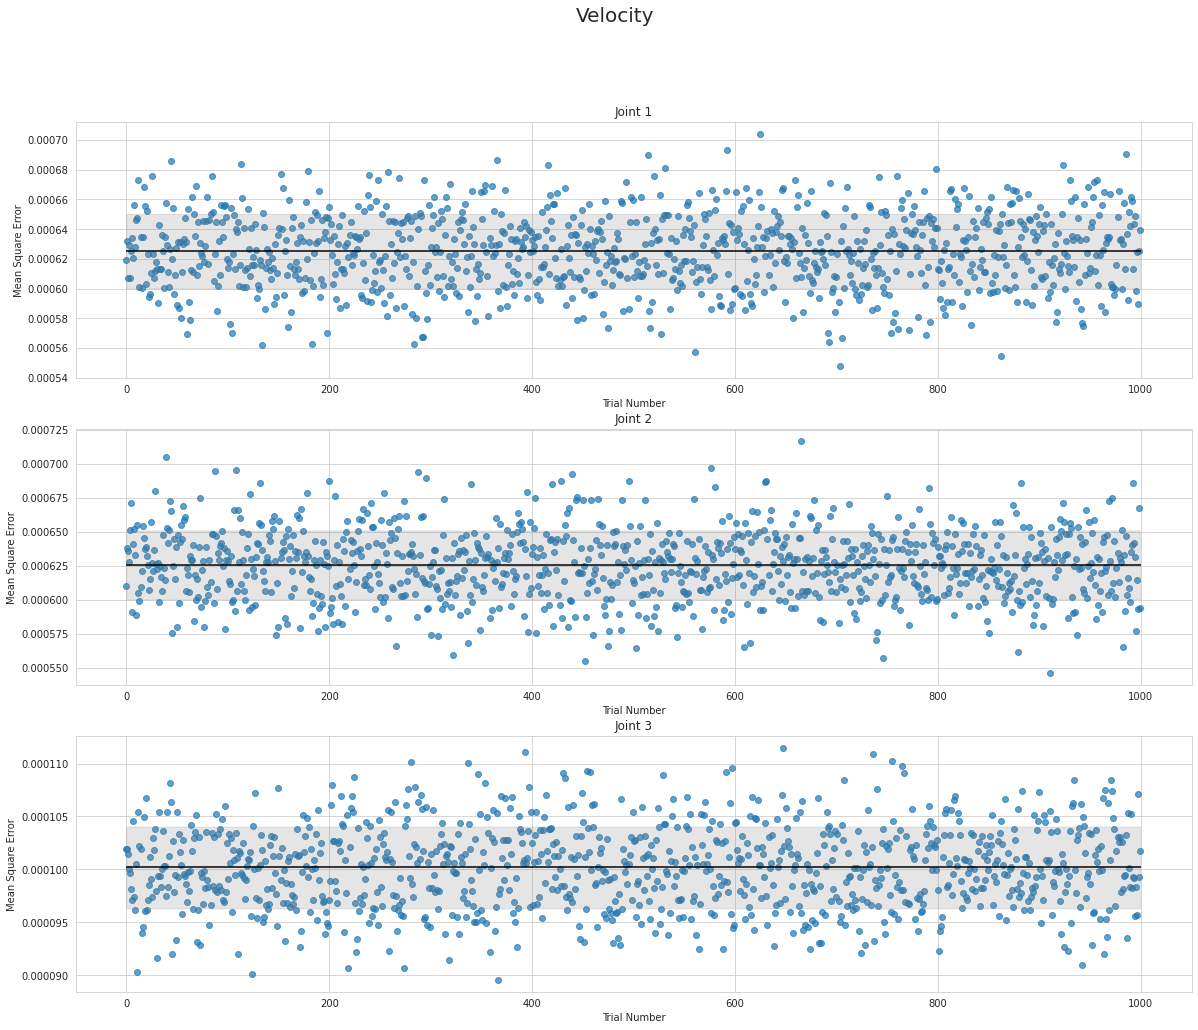

In [ ]:
fig, ax = plt.subplots(3,1,figsize=(20,16))

fig.suptitle('Velocity', fontsize=20)
for i in range(3):
    joint_number = i + 1
    joint_MSE_curr = np.array(joint_MSE_vel[joint_number])
    trial_arr = np.arange(len(joint_MSE_curr))
    ax[i].scatter(trial_arr, joint_MSE_curr, label='Joint 1',
                  linewidths=1,
                  alpha=0.7)
    # dyfit = joint_MSE_curr*0.00436332
    # ax[i].fill_between(trial_arr, joint_MSE_curr-dyfit, joint_MSE_curr+dyfit,
    #                    color='gray', alpha=0.2)
    mean_curr = np.mean(joint_MSE_curr)
    std_curr = np.std(joint_MSE_curr)
    mean_arr = np.ones(len(joint_MSE_curr))*mean_curr
    std_curr = np.std(joint_MSE_curr)
    ax[i].hlines(mean_curr, 0, len(joint_MSE_curr))
    ax[i].fill_between(trial_arr, mean_arr-std_curr, mean_arr+std_curr,
                       color='gray', alpha=0.2)
    ax[i].set_xlabel('Trial Number')
    ax[i].set_ylabel('Mean Square Error')
    ax[i].set_title(f'Joint {joint_number}')
plt.show()

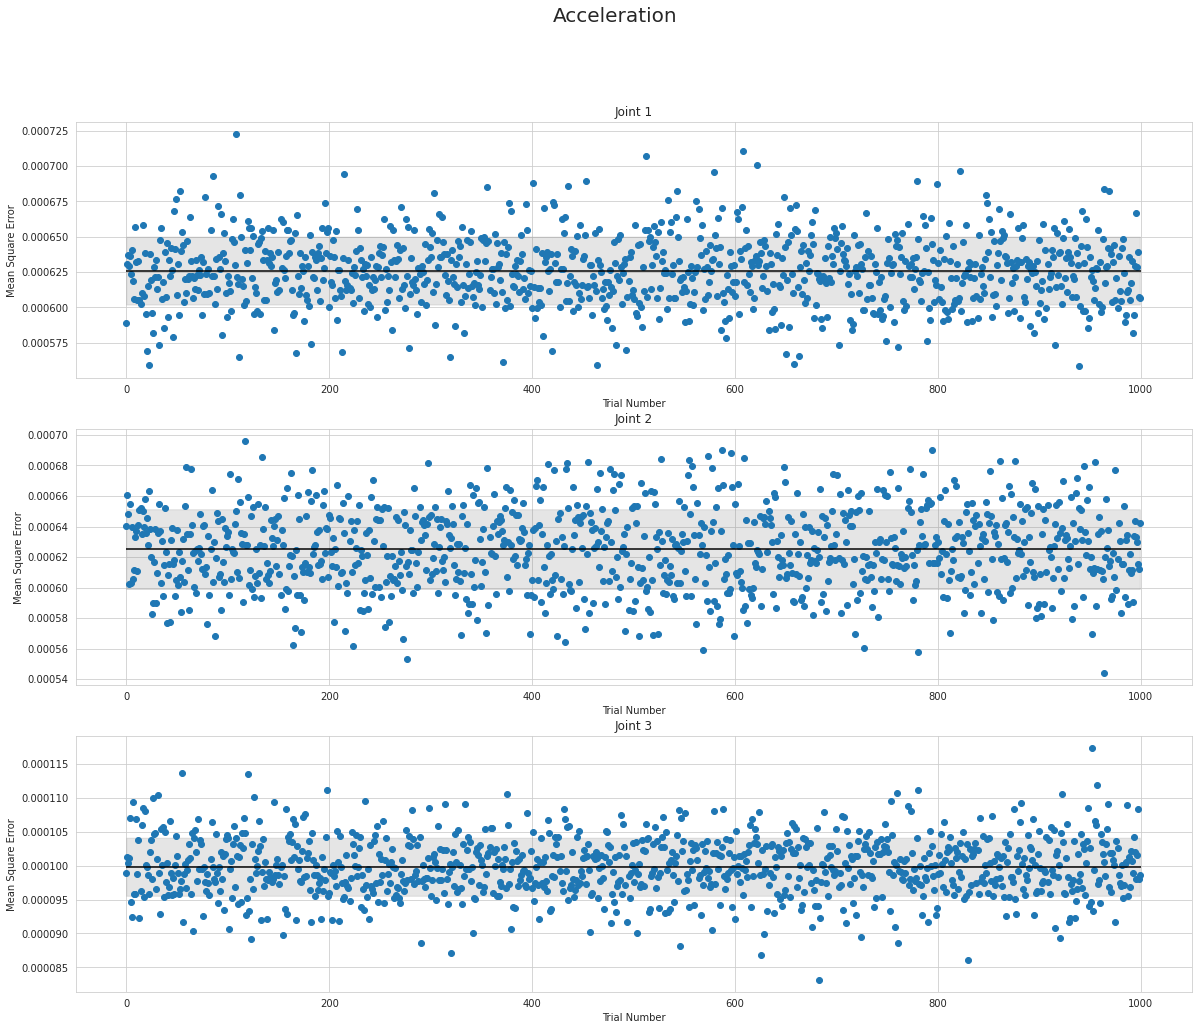

In [ ]:
fig, ax = plt.subplots(3,1,figsize=(20,16))

fig.suptitle('Acceleration', fontsize=20)
for i in range(3):
    joint_number = i + 1
    joint_MSE_curr = joint_MSE_acc[joint_number]
    

    trial_arr = np.arange(len(joint_MSE_curr))
    
    mean_curr = np.mean(joint_MSE_curr)
    std_curr = np.std(joint_MSE_curr)
    mean_arr = np.ones(len(joint_MSE_curr))*mean_curr
    std_curr = np.std(joint_MSE_curr)
    ax[i].hlines(mean_curr, 0, len(joint_MSE_curr))
    ax[i].fill_between(trial_arr, mean_arr-std_curr, mean_arr+std_curr,
                       color='gray', alpha=0.2) 

    ax[i].scatter(trial_arr, joint_MSE_curr, label='Joint 1')
    ax[i].set_xlabel('Trial Number')
    ax[i].set_ylabel('Mean Square Error')
    ax[i].set_title(f'Joint {joint_number}')
plt.show()

## Animation of Allowable Region